In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
data = pd.read_csv("../input/devanagari-character-set/data.csv")

In [3]:
data.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


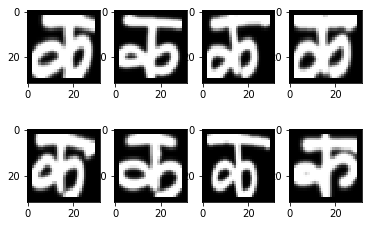

In [4]:
X = data.iloc[:,:-1]
Yd = data.iloc[:,-1]

num_pixels = X.shape[1]
num_classes = 46
img_width = 32
img_height = 32
img_depth = 1

X_images = X.values.reshape(X.shape[0], img_width, img_height)

for i in range(1, 9):
    plt.subplot(240+i)
    plt.imshow(X_images[i], cmap=plt.get_cmap('gray'))
plt.show()

In [5]:
# output in binary/one-hot encoded format
binencoder = LabelBinarizer()
Y = binencoder.fit_transform(Yd)
# data normalization
X /= 255

seed = 2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)

In [6]:
# Training on Simple Neural Network
def nn_model():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
nn = nn_model()

# each epoch was taking 10-12s to train on CPU
# each epoch was taking 4-6s to train on GPU

history_nn = nn.fit(X_train.values, y_train, validation_split=0.20, epochs=10, batch_size=400, verbose=2)

Train on 58880 samples, validate on 14720 samples
Epoch 1/10
 - 4s - loss: 1.2453 - accuracy: 0.6740 - val_loss: 0.7830 - val_accuracy: 0.7926
Epoch 2/10
 - 3s - loss: 0.5794 - accuracy: 0.8479 - val_loss: 0.5123 - val_accuracy: 0.8647
Epoch 3/10
 - 3s - loss: 0.3654 - accuracy: 0.9055 - val_loss: 0.3918 - val_accuracy: 0.8963
Epoch 4/10
 - 3s - loss: 0.2483 - accuracy: 0.9384 - val_loss: 0.3448 - val_accuracy: 0.9043
Epoch 5/10
 - 3s - loss: 0.1826 - accuracy: 0.9557 - val_loss: 0.3016 - val_accuracy: 0.9170
Epoch 6/10
 - 3s - loss: 0.1351 - accuracy: 0.9693 - val_loss: 0.2872 - val_accuracy: 0.9180
Epoch 7/10
 - 3s - loss: 0.0988 - accuracy: 0.9791 - val_loss: 0.2599 - val_accuracy: 0.9272
Epoch 8/10
 - 3s - loss: 0.0729 - accuracy: 0.9863 - val_loss: 0.2503 - val_accuracy: 0.9283
Epoch 9/10
 - 3s - loss: 0.0537 - accuracy: 0.9923 - val_loss: 0.2398 - val_accuracy: 0.9349
Epoch 10/10
 - 4s - loss: 0.0395 - accuracy: 0.9953 - val_loss: 0.2334 - val_accuracy: 0.9339


In [8]:
scores_nn = nn.evaluate(X_test.values, y_test, verbose=0)
print('Accuracy: %.2f%%' % (scores_nn[1]*100))

Accuracy: 93.82%


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_images, Y, test_size=0.20, random_state=seed)

X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(X_train.shape[0], img_width, img_height, img_depth).astype('float32')
X_test = X_test.reshape(X_test.shape[0], img_width, img_height, img_depth).astype('float32')

In [10]:
# Training on Convolutional Neural Network
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, img_depth), activation='relu', name='conv_1'))
    model.add(MaxPooling2D(pool_size=(2,2), name='pool_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='pool_2'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='dense_1'))
    model.add(Dense(50, activation='relu', name='dense_2'))
    model.add(Dense(num_classes, activation='softmax', name='output_layer'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
cnn = cnn_model()

early_stopping_monitor = (EarlyStopping(patience=2))

# each epoch was taking 40-42s to train on CPU
# each epoch was taking 2-6s to train on GPU

history_cnn = cnn.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=200, callbacks=[early_stopping_monitor], verbose=2)

Train on 58880 samples, validate on 14720 samples
Epoch 1/10
 - 4s - loss: 1.2827 - accuracy: 0.6550 - val_loss: 0.4569 - val_accuracy: 0.8709
Epoch 2/10
 - 2s - loss: 0.3702 - accuracy: 0.8892 - val_loss: 0.3061 - val_accuracy: 0.9091
Epoch 3/10
 - 2s - loss: 0.2433 - accuracy: 0.9269 - val_loss: 0.2102 - val_accuracy: 0.9368
Epoch 4/10
 - 2s - loss: 0.1834 - accuracy: 0.9445 - val_loss: 0.1672 - val_accuracy: 0.9518
Epoch 5/10
 - 2s - loss: 0.1462 - accuracy: 0.9540 - val_loss: 0.1479 - val_accuracy: 0.9577
Epoch 6/10
 - 2s - loss: 0.1177 - accuracy: 0.9628 - val_loss: 0.1534 - val_accuracy: 0.9538
Epoch 7/10
 - 2s - loss: 0.0971 - accuracy: 0.9690 - val_loss: 0.1233 - val_accuracy: 0.9612
Epoch 8/10
 - 2s - loss: 0.0832 - accuracy: 0.9736 - val_loss: 0.1297 - val_accuracy: 0.9601
Epoch 9/10
 - 2s - loss: 0.0705 - accuracy: 0.9770 - val_loss: 0.1104 - val_accuracy: 0.9683
Epoch 10/10
 - 2s - loss: 0.0595 - accuracy: 0.9800 - val_loss: 0.1117 - val_accuracy: 0.9679


In [12]:
scores_cnn = cnn.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f%%' % (scores_cnn[1]*100))

Accuracy: 96.50%


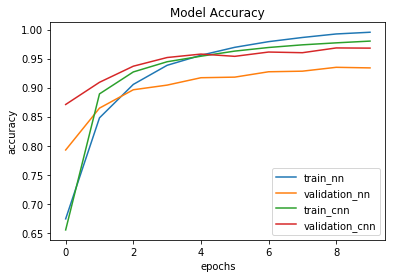

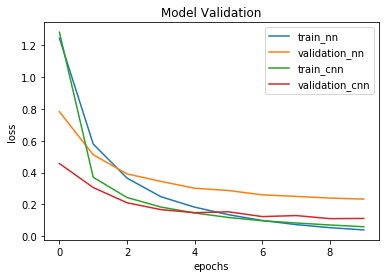

In [13]:
# Summarize history for accuracy
plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_nn', 'validation_nn', 'train_cnn', 'validation_cnn'], loc='lower right')
plt.show()

# Summarize history for loss
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])

plt.title('Model Validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_nn', 'validation_nn', 'train_cnn', 'validation_cnn'], loc='best')
plt.show()

In [14]:
cnn.save('cnn_hindi.h5')